<a href="https://colab.research.google.com/github/jianning1/Capstone-Project/blob/master/EDA_Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and slice data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import string
import spacy 
import os
import sys
import numpy as np

nlp = spacy.load('en', disable=['ner', 'parser'])
import nltk
from nltk.stem.snowball import SnowballStemmer
import gensim 
from gensim.models import Word2Vec
from time import time
from sklearn.model_selection import train_test_split
from collections import defaultdict
import gc
import io

from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, Dropout, Conv1D, GRU
from keras.layers import Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from sklearn.metrics import roc_auc_score
import keras.backend as K
from keras.layers import CuDNNLSTM as LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras import metrics
from tensorflow.python.keras.metrics import Metric


Using TensorFlow backend.


In [3]:
!pip uninstall tensorflow
!pip install tensorflow-gpu==2.1.0

Uninstalling tensorflow-1.15.0:
  Would remove:
    /tensorflow-1.15.0/python3.6/tensorflow-1.15.0.dist-info/*
    /tensorflow-1.15.0/python3.6/tensorflow/*
    /tensorflow-1.15.0/python3.6/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 3.9MB 41.4MB/s 
     |████████████████████████████████| 450kB 34.7MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


In [0]:
from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np


from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import keras.backend as K

In [5]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
#import io
mydata = pd.read_csv('/gdrive/My Drive/Full-Economic-News-DFE.csv', encoding = "ISO-8859-1")

In [7]:
data = mydata[['_unit_id','positivity', 'relevance', 'date','headline', 'text']]

data.head()

,_unit_id,positivity,relevance,date,headline,text
0,842613455,3.0,yes,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...
1,842613456,NaN,no,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...
2,842613457,NaN,no,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...
3,842613458,NaN,no,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...
4,842613459,3.0,yes,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...


# Exploratory Data Analysis

In [8]:
data['positivity'].fillna(0, inplace = True)
data.head(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,_unit_id,positivity,relevance,date,headline,text
0,842613455,3.0,yes,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...
1,842613456,0.0,no,8/21/07,The Morning Brief: White House Seeks to Limit ...,The Wall Street Journal Online</br></br>The Mo...
2,842613457,0.0,no,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,WASHINGTON -- In an effort to achieve banking ...
3,842613458,0.0,no,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,The statistics on the enormous costs of employ...
4,842613459,3.0,yes,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...


In [9]:
dist = data[['_unit_id','relevance']].groupby('relevance').count()
dist

,_unit_id
relevance,
no,6571
not sure,9
yes,1420


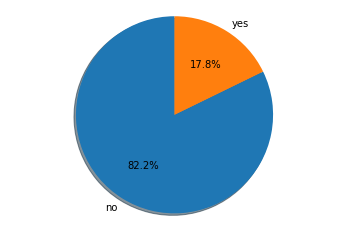

In [10]:
fig1, ax1 = plt.subplots()
sizes = [6571, 1420]
label = ['no', 'yes']

ax1.pie(sizes, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

In [11]:
dist = data[data['positivity']!=0][['positivity','_unit_id']].groupby('positivity').count()
dist

,_unit_id
positivity,
2.0,35
3.0,343
4.0,255
5.0,205
6.0,214
7.0,295
8.0,71
9.0,2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


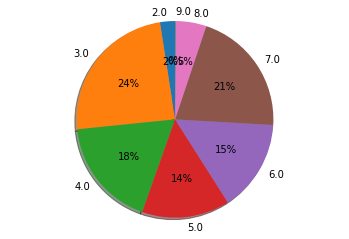

In [0]:
fig1, ax1 = plt.subplots()
sizes = dist.values
label = dist.index.tolist()

ax1.pie(sizes, labels=label, autopct='%1.0f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

## Remove ambiguious data

In [13]:
data = data[data.relevance != 'not sure']
data.relevance = data.relevance.map(dict(yes=1, no=0))
data['texts'] = data['headline'] + (' ') + data['text']

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Length and word counts of texts

In [14]:
# length of headline and text for all news
texts_len_r = data['texts'].str.len()
# number of words in headline for irrelevant news
texts_word_counts_r = data['texts'].str.split().str.len()

print('Total texts has {} to {} characters, {} to {} words.'.format(texts_len_r.min(),
                                                                    texts_len_r.max(),
                                                                    texts_word_counts_r.min(),
                                                                    texts_word_counts_r.max()))

Total texts has 133 to 5345 characters, 10 to 870 words.


Text(0.5, 1.0, 'number of words in headline and text')

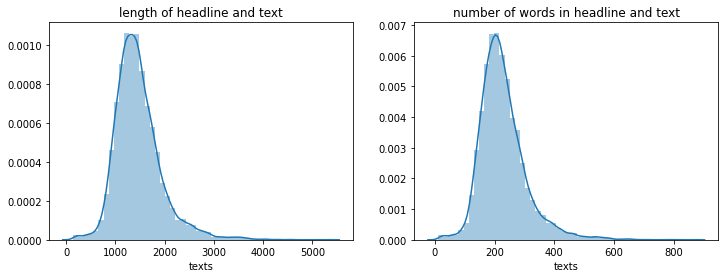

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(texts_len_r, ax = axes[0])
axes[0].set_title('length of headline and text')
sns.distplot(texts_word_counts_r, ax = axes[1])
axes[1].set_title('number of words in headline and text')

## Ngrams 

In [0]:

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '']
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

In [0]:
# Unigrams
texts_unigrams = defaultdict(int)

for text in data['texts']:
    for word in generate_ngrams(text):
        texts_unigrams[word] += 1
        
texts_unigrams = pd.DataFrame(sorted(texts_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
texts_bigrams = defaultdict(int)

for text in data['texts']:
    for word in generate_ngrams(text, n_gram=2):
        texts_bigrams[word] += 1
        
texts_bigrams = pd.DataFrame(sorted(texts_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
texts_trigrams = defaultdict(int)

for text in data['texts']:
    for word in generate_ngrams(text, n_gram=3):
        texts_trigrams[word] += 1
        
texts_trigrams = pd.DataFrame(sorted(texts_trigrams.items(), key=lambda x: x[1])[::-1])

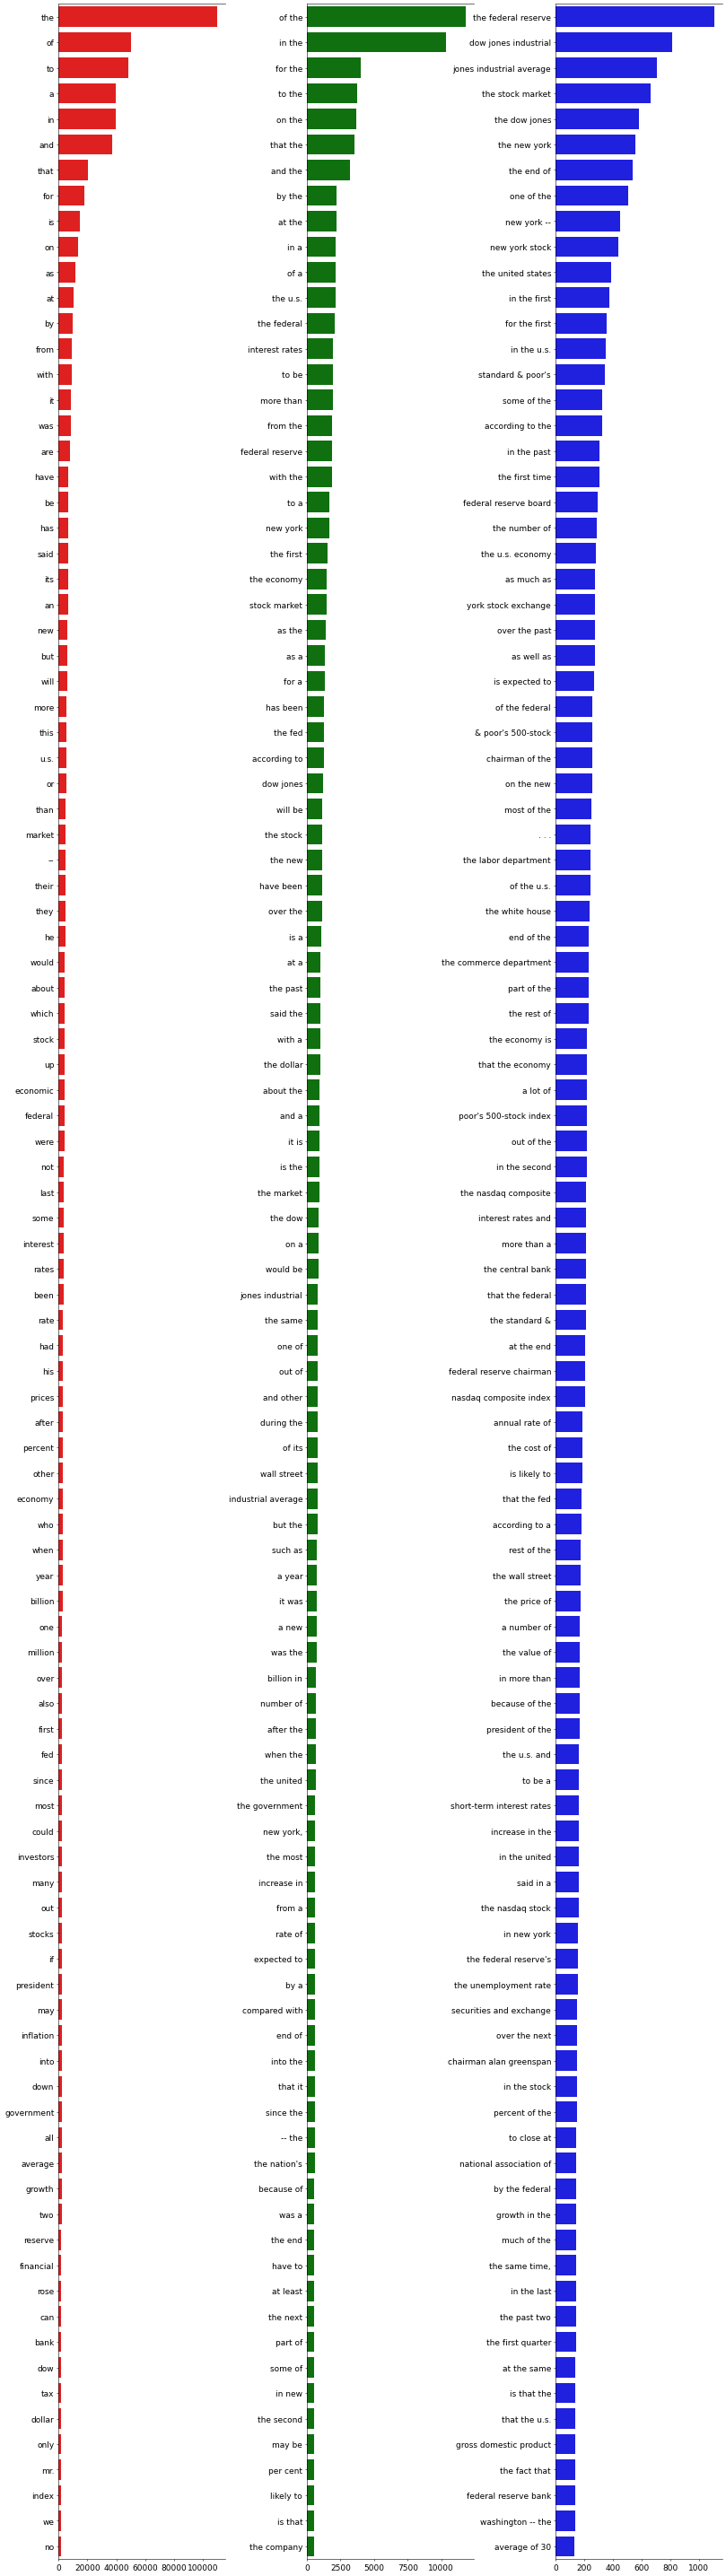

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 60), dpi=50)
plt.tight_layout(pad=10)

sns.barplot(y=texts_unigrams[0].values[:N], x=texts_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=texts_bigrams[0].values[:N], x=texts_bigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=texts_trigrams[0].values[:N], x=texts_trigrams[1].values[:N], ax=axes[2], color='blue')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

## Check Embeddings Coverage 

In [0]:
import operator
def build_vocab(X):
    
    news = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for n in news:
        for word in n:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

### GloVe Embedding Coverage

In [20]:
print('Loading GloVe Embeddings.')

glove_embeddings = {}
f = open('/gdrive/My Drive/glove.42B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_embeddings))


Loading GloVe Embeddings.
Found 1917495 word vectors.


In [21]:
texts_glove_oov, texts_glove_vocab_coverage, texts_glove_text_coverage = check_embeddings_coverage(data['texts'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in texts'.format(texts_glove_vocab_coverage, texts_glove_text_coverage))

GloVe Embeddings cover 23.86% of vocabulary and 75.26% of text in texts


### FastText Embedding Coverage

In [30]:
fin = io.open('/gdrive/My Drive/wiki-news-300d-1M-subword.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
n, d = map(int, fin.readline().split())
fasttext_embeddings = {}
for line in fin:
    tokens = line.rstrip().split(' ')
    fasttext_embeddings[tokens[0]] = map(float, tokens[1:])
fin.close()

print('Found %s word vectors.' % len(fasttext_embeddings))

Found 999994 word vectors.


In [23]:
texts_fasttext_oov, texts_fasttext_vocab_coverage, texts_fasttext_text_coverage = check_embeddings_coverage(data['texts'], fasttext_embeddings)
print('Fasttext Embeddings cover {:.2%} of vocabulary and {:.2%} of text in texts'.format(texts_fasttext_vocab_coverage, texts_fasttext_text_coverage))

Fasttext Embeddings cover 36.14% of vocabulary and 87.82% of text in texts


In [24]:
del fasttext_embeddings, texts_glove_oov, texts_glove_vocab_coverage, texts_glove_text_coverage, texts_fasttext_oov, texts_fasttext_vocab_coverage, texts_fasttext_text_coverage
gc.collect()

0

# Pre-processing

## Remove url and html in text 

In [0]:
def rm_url(contents):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r' ',contents)

def rm_html(contents):
    html=re.compile(r'<.*?>')
    return html.sub(r' ',contents)

In [27]:
data['texts'] = data['texts'].apply(rm_url)
data['texts'] = data['texts'].apply(rm_html)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Remove non-alphabet characters and lower case

In [28]:
data['texts'] = [re.sub("u.s.", 'us', str(line)).lower() for line in data['texts']]
data['texts'] = [re.sub("[^A-Za-z']+", ' ', str(line)).lower() for line in data['texts']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Lemmatization and Stopwords removal

In [29]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

t = time()

data['texts'] = [cleaning(doc) for doc in nlp.pipe(data['texts'], batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.01 mins


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## Embedding Coverage on cleaned data

In [31]:
texts_glove_oov, texts_glove_vocab_coverage, texts_glove_text_coverage = check_embeddings_coverage(data['texts'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in texts'.format(texts_glove_vocab_coverage, texts_glove_text_coverage))

texts_fasttext_oov, texts_fasttext_vocab_coverage, texts_fasttext_text_coverage = check_embeddings_coverage(data['texts'], fasttext_embeddings)
print('Fasttext Embeddings cover {:.2%} of vocabulary and {:.2%} of text in texts'.format(texts_fasttext_vocab_coverage, texts_fasttext_text_coverage))

GloVe Embeddings cover 84.01% of vocabulary and 98.79% of text in texts
Fasttext Embeddings cover 67.33% of vocabulary and 97.28% of text in texts


In [32]:
import gc
del fasttext_embeddings, texts_glove_oov, texts_glove_vocab_coverage, texts_glove_text_coverage, texts_fasttext_oov, texts_fasttext_vocab_coverage, texts_fasttext_text_coverage
gc.collect()

0

## Data check after cleaning

In [33]:
# length of headline and text for all news
texts_len_r = data['texts'].str.len()
# number of words in headline for irrelevant news
texts_word_counts_r = data['texts'].str.split().str.len()

print('Total texts has {} to {} characters, {} to {} words.'.format(texts_len_r.min(),
                                                                    texts_len_r.max(),
                                                                    texts_word_counts_r.min(),
                                                                    texts_word_counts_r.max()))

Total texts has 73 to 3086 characters, 10 to 432 words.


Text(0.5, 1.0, 'number of words in headline and text')

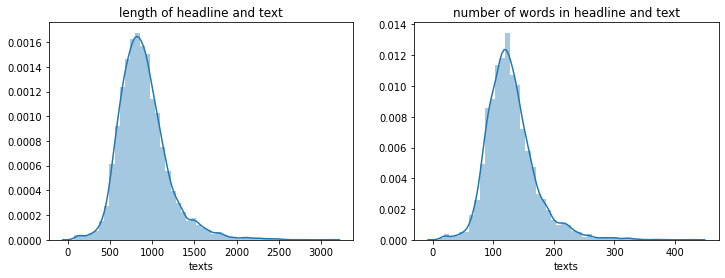

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(texts_len_r, ax = axes[0])
axes[0].set_title('length of headline and text')
sns.distplot(texts_word_counts_r, ax = axes[1])
axes[1].set_title('number of words in headline and text')

In [0]:
#r = data # all data
r = data[data['relevance']==1] # for relevant news
#r = data[data['relevance']==0] # for irrelevant news
#r = data[data['positivity']==9] # for positivity = 2-9


# Unigrams
texts_unigrams = defaultdict(int)

for text in r['texts']:
    for word in generate_ngrams(text):
        texts_unigrams[word] += 1
        
texts_unigrams = pd.DataFrame(sorted(texts_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
texts_bigrams = defaultdict(int)

for text in r['texts']:
    for word in generate_ngrams(text, n_gram=2):
        texts_bigrams[word] += 1
        
texts_bigrams = pd.DataFrame(sorted(texts_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
texts_trigrams = defaultdict(int)

for text in r['texts']:
    for word in generate_ngrams(text, n_gram=3):
        texts_trigrams[word] += 1
        
texts_trigrams = pd.DataFrame(sorted(texts_trigrams.items(), key=lambda x: x[1])[::-1])

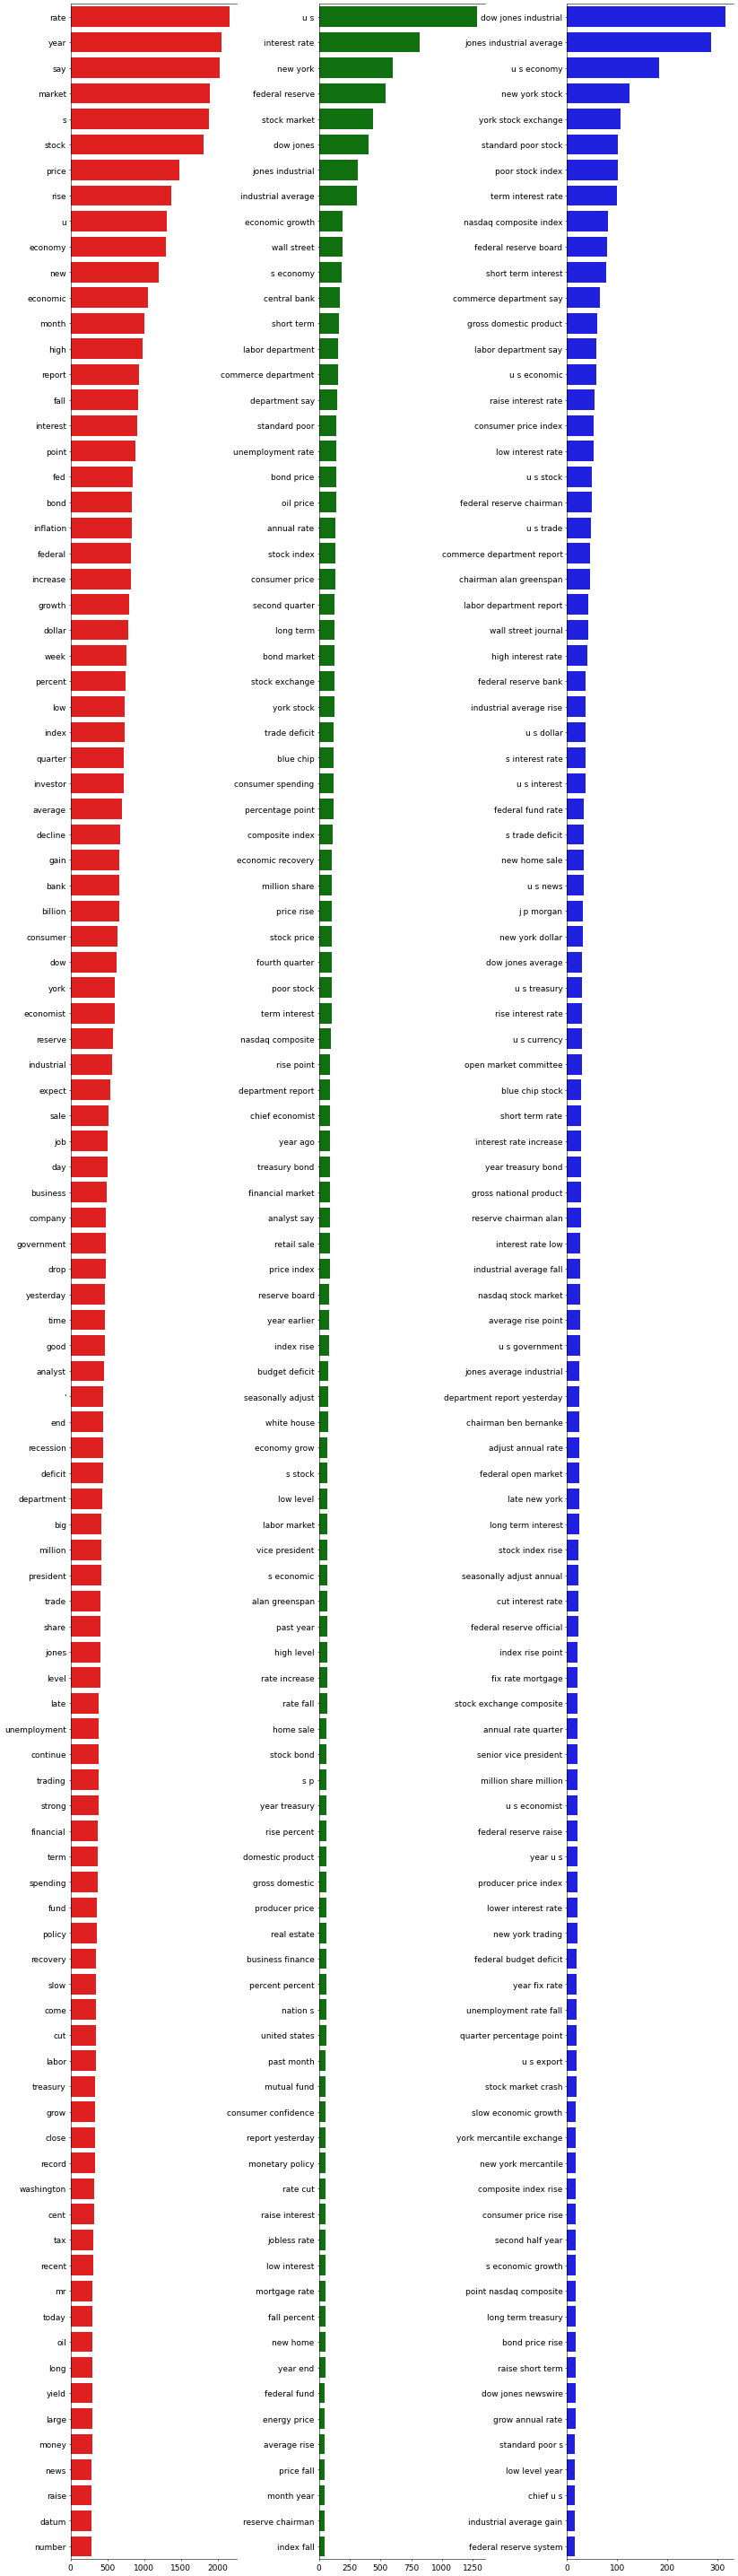

In [36]:
N = 100
fig, axes = plt.subplots(ncols=3, figsize=(18, 60), dpi=50)
plt.tight_layout(pad=10)

sns.barplot(y=texts_unigrams[0].values[:N], x=texts_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=texts_bigrams[0].values[:N], x=texts_bigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=texts_trigrams[0].values[:N], x=texts_trigrams[1].values[:N], ax=axes[2], color='blue')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

In [37]:
print(texts_unigrams[0].values[:10])
print(texts_bigrams[0].values[:10])
print(texts_trigrams[0].values[:10])

['rate' 'year' 'say' 'market' 's' 'stock' 'price' 'rise' 'u' 'economy']
['u s' 'interest rate' 'new york' 'federal reserve' 'stock market'
 'dow jones' 'jones industrial' 'industrial average' 'economic growth'
 'wall street']
['dow jones industrial' 'jones industrial average' 'u s economy'
 'new york stock' 'york stock exchange' 'standard poor stock'
 'poor stock index' 'term interest rate' 'nasdaq composite index'
 'federal reserve board']


# Text Classification

## Training and Testing set split

In [0]:
train1, test1, relevance_train, relevance_test = train_test_split(data['texts'], data['relevance'], test_size=0.2, random_state=1)

In [39]:
train_count = relevance_train.groupby(relevance_train).count()
test_count = relevance_test.groupby(relevance_test).count()
label = [0, 1]
print("training set\n", train_count)
print("\ntesting set\n",test_count)

training set
 relevance
0    5244
1    1148
Name: relevance, dtype: int64

testing set
 relevance
0    1327
1     272
Name: relevance, dtype: int64


## Baselines - Naive Bayes and SVM

In [40]:
#from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# Naïve Bayes Model:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC Model:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Train both models on the moviereviews.tsv training set:
text_clf_nb.fit(train1, relevance_train)
text_clf_lsvc.fit(train1, relevance_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [0]:
predictions_nb = text_clf_nb.predict(test1)
predictions_SVM = text_clf_lsvc.predict(test1)

In [42]:
# Report the confusion matrix

from sklearn import metrics

print("Naive Bayes Confusion Matrix")
print(metrics.confusion_matrix(relevance_test,predictions_nb))

# Print a classification report
print(metrics.classification_report(relevance_test,predictions_nb))

# Print the overall accuracy
print(metrics.accuracy_score(relevance_test,predictions_nb))


Naive Bayes Confusion Matrix
[[1327    0]
 [ 272    0]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1327
           1       0.00      0.00      0.00       272

    accuracy                           0.83      1599
   macro avg       0.41      0.50      0.45      1599
weighted avg       0.69      0.83      0.75      1599

0.8298936835522202


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
print("Linear SVM Confusion Matrix")
print(metrics.confusion_matrix(relevance_test,predictions_SVM))

# Print a classification report
print(metrics.classification_report(relevance_test,predictions_SVM))

# Print the overall accuracy
print(metrics.accuracy_score(relevance_test,predictions_SVM))

Linear SVM Confusion Matrix
[[1231   96]
 [ 211   61]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1327
           1       0.39      0.22      0.28       272

    accuracy                           0.81      1599
   macro avg       0.62      0.58      0.59      1599
weighted avg       0.77      0.81      0.79      1599

0.8080050031269543


## Bi-LSTM

In [0]:
# some configuration

MAX_SEQUENCE_LENGTH = 427   # max sentence length 427 words
EMBEDDING_DIM = 300    # word vector dimension


### Word Embedding Weights

In [45]:
# T: number of obersavatons in dataset

# load in pre-trained word vectors
# size: MAX_VOCAB_SIZE x word vector dimension
MAX_VOCAB_SIZE = 50000     # how many words will be used from dictionary 

print('Loading word vectors...')
word2vec = glove_embeddings

# load dataset
sentences = data['texts'].fillna("DUMMY_VALUE").values

# convert the sentences (strings) into integers
# return a list of the index of every word in every sentence
num_words = MAX_VOCAB_SIZE
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(sentences)   # word counts on unique words, see below

# get word -> integer mapping
# word2idx: number of unique words with index (Dictionary of word index)
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Loading word vectors...
Found 34834 unique tokens.


In [46]:
# prepare embedding matrix
# use the word and index in word2idx to look for the word vector (numeric)
# embedding_matrix
# size: # of unique words x D
n = 0
uncovered_words = {}
print('Filling pre-trained embeddings...')
num_words = max(MAX_VOCAB_SIZE,len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        #print(embedding_vector)
        if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
        else:
            n = n + 1
            uncovered_words[n] = word
print('{}, or {:.2%} of total {} unique words are not covered'.format(n, n/len(word2idx), len(word2idx)))

Filling pre-trained embeddings...
5570, or 15.99% of total 34834 unique words are not covered


### Padding

In [47]:
# pad sequences so that we get a N x T matrix
# Transfer sentences with variable length to max_sequence_length
# size: T x max_sequence_length

# training set
sequences = tokenizer.texts_to_sequences(train1.values)  # list, size T x number of words in each line (each line fluctuates)
train_c = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of training data tensor:', train_c.shape)

# testing set
sequences = tokenizer.texts_to_sequences(test1.values)  # list, size T x number of words in each line (each line fluctuates)
test_c = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', test_c.shape)

Shape of training data tensor: (6392, 427)
Shape of test data tensor: (1599, 427)


### Data Augmentation

In [0]:
## word list
words = [value for value, key in word2idx.items()]

In [0]:
## Function to find synonym of words 
import spacy
nlp = spacy.load('en', parser=False)
def check_lemma(t,w) :
    r = [d for d in t if (nlp(d.text)[0].lemma_ != nlp(w.text)[0].lemma_)]
    return r

def get_word_synonym(word):
  filtered_words = [w for w in word.vocab if (not w.lower_ in stop) and w.is_lower == word.is_lower and w.prob >= -15] ## (not w.lower_ in stop) and
  similarity = sorted(filtered_words, key=lambda w: word.similarity(w), reverse=True)
  filtered_similarity = check_lemma(similarity[:30], word)
  return filtered_similarity[:3]

In [0]:
## to be continued

### Model

#### Xgboost

In [0]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier

xgb_classifir = XGBClassifier(learning_rate=0.01,
                              num_round=100,
                              max_depth=10,
                              min_child_weight=2,
                              colsample_bytree=0.7,
                              subsample=0.8,
                              gamma=0.3,
                              reg_alpha=1e-5,
                              reg_lambda=1,
                              n_estimators=1000,
                              objective='binary:logistic',
                              eval_metric=["auc", "logloss", "error"],
                              early_stopping_rounds=50)

##### model tuning
from sklearn.model_selection import GridSearchCV

params = {
     'max_depth': list(range(5, 11)),
     'learning_rate': list(np.arange(0.05, 0.30, 0.05)),
     'gamma': list(np.arange(0.01, 0.06, 0.01)),
     'min_child_weight': list(range(1, 6)),
   
     # fixed params
     'n_estimators' : [1500],
     'n_jobs': [4],
     'objective': ['binary:logistic'],
     'eval_metric' : ['logloss'],
     'random_state': [42]
 }
model = XGBClassifier(tree_method='gpu_hist')
cv = GridSearchCV(model, params, cv=5, n_jobs=4, scoring='roc_auc')

cv.fit(train_c, relevance_train)

In [51]:
xgb_classifir.fit(train_c, relevance_train.values, eval_set=[(train_c, relevance_train.values),(test_c, relevance_test.values)])
evals_result = xgb_classifir.evals_result()

[0]	validation_0-auc:0.834022	validation_0-logloss:0.68737	validation_0-error:0.142053	validation_1-auc:0.596422	validation_1-logloss:0.688713	validation_1-error:0.227642
[1]	validation_0-auc:0.904213	validation_0-logloss:0.681583	validation_0-error:0.111233	validation_1-auc:0.609057	validation_1-logloss:0.684579	validation_1-error:0.195122
[2]	validation_0-auc:0.938836	validation_0-logloss:0.676007	validation_0-error:0.107635	validation_1-auc:0.607859	validation_1-logloss:0.680636	validation_1-error:0.193246
[3]	validation_0-auc:0.954791	validation_0-logloss:0.670581	validation_0-error:0.10826	validation_1-auc:0.632027	validation_1-logloss:0.676643	validation_1-error:0.186992
[4]	validation_0-auc:0.964918	validation_0-logloss:0.665171	validation_0-error:0.109043	validation_1-auc:0.636703	validation_1-logloss:0.672536	validation_1-error:0.178862
[5]	validation_0-auc:0.969417	validation_0-logloss:0.659907	validation_0-error:0.109981	validation_1-auc:0.633161	validation_1-logloss:0.66863

In [0]:
y_pred_xgb = xgb_classifir.predict(test_c)

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
confusion_matrix(relevance_test, y_pred_xgb)

array([[1318,    9],
       [ 269,    3]])

In [55]:
accuracy = (1318+3)/(1599)
accuracy

0.8261413383364603

#### Bi-LSTM - Learning rate 0.001, epoches 13

Building Bi-LSTM model...
Training model...
Train on 5113 samples, validate on 1279 samples
Epoch 1/13
5113/5113 [==============================] - 13s 3ms/sample - loss: 0.4569 - tp: 1.0000 - fp: 3.0000 - tn: 4220.0000 - fn: 889.0000 - accuracy: 0.8255 - precision: 0.2500 - recall: 0.0011 - auc: 0.6124 - val_loss: 0.4418 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1021.0000 - val_fn: 258.0000 - val_accuracy: 0.7983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7605
Epoch 2/13
5113/5113 [==============================] - 7s 1ms/sample - loss: 0.4174 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4223.0000 - fn: 890.0000 - accuracy: 0.8259 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7213 - val_loss: 0.4232 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1021.0000 - val_fn: 258.0000 - val_accuracy: 0.7983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7865
Epoch 3/13
5113/5113 [==============================] - 7s 1ms/sample - loss: 0

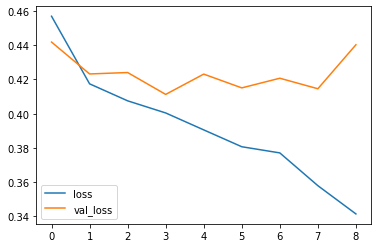

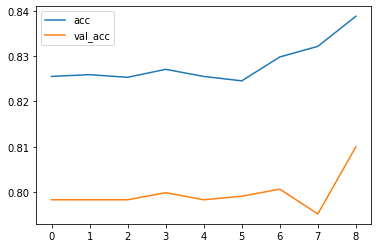

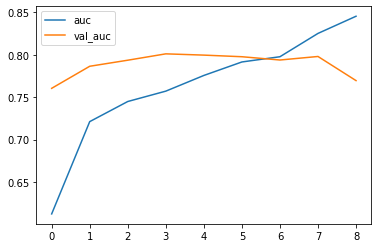

1599/1599 [==============================] - 1s 644us/sample - loss: 0.3983 - tp: 6.0000 - fp: 9.0000 - tn: 1318.0000 - fn: 266.0000 - accuracy: 0.8280 - precision: 0.4000 - recall: 0.0221 - auc: 0.7533


[0.3982845684787197,
 6.0,
 9.0,
 1318.0,
 266.0,
 0.82801753,
 0.4,
 0.022058824,
 0.75334543]

In [63]:
# some configuration
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'

VALIDATION_SPLIT = 0.2   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 13   # number of complete passes through the training dataset
LEARNING_RATE = 0.001

print('Building Bi-LSTM model...')

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

model = tf.keras.Sequential([
    #Embedding

     tf.keras.layers.Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
     #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
     tf.keras.layers.GlobalAveragePooling1D(),
     tf.keras.layers.Dense(32, activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
  loss = 'binary_crossentropy',
  optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
  metrics = METRICS,
  
)


# Training model:
# parameters: batch_size, epoches
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
# load a saved model

from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(relevance_train.values), relevance_train.values)
#class_weight_dict = dict(enumerate(class_weights))

print('Training model...')
r = model.fit(
  train_c,
  relevance_train.values,
  batch_size = BATCH_SIZE,
  epochs = EPOCHS,
  validation_split = VALIDATION_SPLIT,
  callbacks=[es]
  #callbacks=[es, mc],
  #class_weight = class_weight_dict
  #use_multiprocessing=True
)

#saved_model = tf.keras.models.load_model('best_model.h5')
#saved_model.summary()

model.summary()

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# auc
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.legend()
plt.show()

#saved_model.evaluate(x = test_c, y = relevance_test.values)
model.evaluate(x = test_c, y = relevance_test.values)

#### Bi-LSTM - Learning rate 0.0001, epoches 102

Building Bi-LSTM model...
Training model...
Train on 5113 samples, validate on 1279 samples
Epoch 1/1000
5113/5113 [==============================] - 21s 4ms/sample - loss: 0.6738 - tp: 9.0000 - fp: 58.0000 - tn: 4165.0000 - fn: 881.0000 - accuracy: 0.8164 - precision: 0.1343 - recall: 0.0101 - auc: 0.5113 - val_loss: 0.6628 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1021.0000 - val_fn: 258.0000 - val_accuracy: 0.7983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4630
Epoch 2/1000
5113/5113 [==============================] - 15s 3ms/sample - loss: 0.6453 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4223.0000 - fn: 890.0000 - accuracy: 0.8259 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4960 - val_loss: 0.6379 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1021.0000 - val_fn: 258.0000 - val_accuracy: 0.7983 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4646
Epoch 3/1000
5113/5113 [==============================] - 8s 1ms/sample -

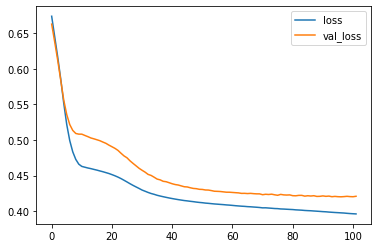

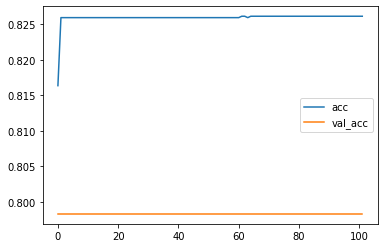

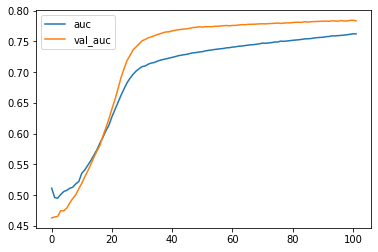

1599/1599 [==============================] - 1s 714us/sample - loss: 0.4089 - tp: 1.0000 - fp: 0.0000e+00 - tn: 1327.0000 - fn: 271.0000 - accuracy: 0.8305 - precision: 1.0000 - recall: 0.0037 - auc: 0.7332


[0.40893136493260596,
 1.0,
 0.0,
 1327.0,
 271.0,
 0.8305191,
 1.0,
 0.0036764706,
 0.7332397]

In [0]:
# some configuration
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'

VALIDATION_SPLIT = 0.2   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 1000   # number of complete passes through the training dataset
LEARNING_RATE = 0.00001

print('Building Bi-LSTM model...')

model = tf.keras.Sequential([
    #Embedding

     tf.keras.layers.Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
     tf.keras.layers.GlobalAveragePooling1D(),
     tf.keras.layers.Dense(32, activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
  loss = 'binary_crossentropy',
  optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
  metrics = METRICS,
  
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

print('Training model...')
r = model.fit(
  train_c,
  relevance_train.values,
  batch_size = BATCH_SIZE,
  epochs = EPOCHS,
  validation_split = VALIDATION_SPLIT,
  callbacks=[es]
)

model.summary()

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# auc
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.legend()
plt.show()

model.evaluate(x = test_c, y = relevance_test.values)

#### Bi-LSTM + Resample (all else equal with model 1)
*   ROS performs worse accuracy
*   SMOTE performs almost same accuracy
*   adjust class weight peforms worse accuracy






/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(7866, 427) (7866,)
Building Bi-LSTM model...
Training model...
Train on 6292 samples, validate on 1574 samples
Epoch 1/1000
6292/6292 [==============================] - 14s 2ms/sample - loss: 0.4604 - tp: 8.0000 - fp: 31.0000 - tn: 5136.0000 - fn: 1117.0000 - accuracy: 0.8175 - precision: 0.2051 - recall: 0.0071 - auc: 0.6289 - val_loss: 2.2423 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 77.0000 - val_fn: 1497.0000 - val_accuracy: 0.0489 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5042
Epoch 2/1000
6292/6292 [==============================] - 9s 1ms/sample - loss: 0.4190 - tp: 3.0000 - fp: 7.0000 - tn: 5160.0000 - fn: 1122.0000 - accuracy: 0.8206 - precision: 0.3000 - recall: 0.0027 - auc: 0.7337 - val_loss: 1.6696 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 77.0000 - val_fn: 1497.0000 - val_accuracy: 0.0489 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5987
Epoch 3/1000
6292/6292 [==============================] - 9s 1ms/sampl

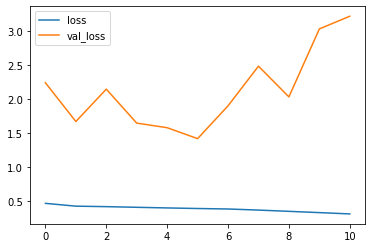

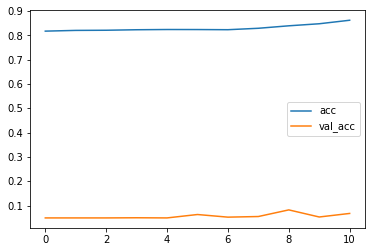

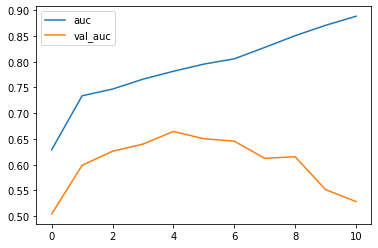

1599/1599 [==============================] - 1s 663us/sample - loss: 0.4149 - tp: 66.0000 - fp: 72.0000 - tn: 1255.0000 - fn: 206.0000 - accuracy: 0.8261 - precision: 0.4783 - recall: 0.2426 - auc: 0.7502


[0.41489817234707893,
 66.0,
 72.0,
 1255.0,
 206.0,
 0.82614136,
 0.47826087,
 0.24264705,
 0.75018144]

In [74]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
#ROS = RandomOverSampler(sampling_strategy=0.5, random_state=777)
smote = SMOTE(sampling_strategy=0.5, k_neighbors=2, random_state=777)
#train1_sm, relevance_train_sm = ROS.fit_sample(train_c, relevance_train)
train1_sm, relevance_train_sm = smote.fit_sample(train_c, relevance_train)
print(train1_sm.shape, relevance_train_sm.shape)
import collections
collections.Counter(relevance_train_sm)

# some configuration
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'

MAX_SEQUENCE_LENGTH = 427   # max sentence length 427 words
EMBEDDING_DIM = 300    # word vector dimension
VALIDATION_SPLIT = 0.2   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 1000   # number of complete passes through the training dataset
LEARNING_RATE = 0.001

print('Building Bi-LSTM model...')
model = tf.keras.Sequential([
    #Embedding

     tf.keras.layers.Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
     tf.keras.layers.GlobalAveragePooling1D(),
     tf.keras.layers.Dense(32, activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
  loss = 'binary_crossentropy',
  optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
  metrics = METRICS,
  
)


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(relevance_train.values), relevance_train.values)
#class_weight_dict = dict(enumerate(class_weights))

print('Training model...')
r = model.fit(
  #train_c,
  #relevance_train.values,
  train1_sm,
  relevance_train_sm,
  batch_size = BATCH_SIZE,
  epochs = EPOCHS,
  validation_split = VALIDATION_SPLIT,
  callbacks=[es]#,
  #class_weight = class_weight_dict
)

model.summary()

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# auc
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.legend()
plt.show()

#saved_model.evaluate(x = test_c, y = relevance_test.values)
model.evaluate(x = test_c, y = relevance_test.values)

# Sentiment Analysis

## Training and Testing set split

In [75]:
data_new = data[data['relevance']==1]
len(data_new)

1420

In [76]:
data_new

,_unit_id,positivity,relevance,date,headline,text,texts
0,842613455,3.0,1,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...,yield cd fall late week new york yield certifi...
4,842613459,3.0,1,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...,currency trading dollar remain tight range ami...
5,842613460,3.0,1,11/23/11,"Stocks Fall Again; BofA, Alcoa Slide","Stocks declined, as investors weighed slower-t...",stock fall bofa alcoa slide stock decline inve...
9,842613464,4.0,1,11/1/84,U.S. Dollar Falls Against Most Currencies; Dec...,The U.S. dollar declined against most major fo...,u s dollar fall currency decline soften bond r...
12,842613467,4.0,1,8/3/10,Defending Yourself Against Deflation,Author: James B. Stewart</br></br>The dreaded ...,defend youslf deflation author james b stewart...
...,...,...,...,...,...,...,...
7973,830985610,7.0,1,10/21/94,"Housing Starts Grow, Raising Inflation Fears: ...",Housing starts surged by 4.4 percent last mont...,housing start grow raise inflation fear econom...
7974,830985611,3.0,1,8/24/71,Profits Often Evasive In Stock Mart Rallies Gr...,"When it comes to actually cashing in, stock ma...",profit evasive stock mart rally greer philip c...
7984,830985621,8.0,1,1/16/94,Salomon Sounds a Wary Note on the Economy,Perhaps nothing about the Clinton administrati...,salomon sound wary note economy clinton admini...
7987,830985624,5.0,1,1/29/06,The Great Terror; A massive new history of Hit...,Looking at the enormous -- and incessant -- ti...,great terror massive new history hitler tyrann...


In [77]:
data_new['pos2']= (data_new['positivity']==2.0)*1
data_new['pos3']= (data_new['positivity']==3.0)*1
data_new['pos4']= (data_new['positivity']==4.0)*1
data_new['pos5']= (data_new['positivity']==5.0)*1
data_new['pos6']= (data_new['positivity']==6.0)*1
data_new['pos7']= (data_new['positivity']==7.0)*1
data_new['pos8']= (data_new['positivity']==8.0)*1
data_new['pos9']= (data_new['positivity']==9.0)*1
data_new


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,_unit_id,positivity,relevance,date,headline,text,texts,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9
0,842613455,3.0,1,8/14/91,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of dep...,yield cd fall late week new york yield certifi...,0,1,0,0,0,0,0,0
4,842613459,3.0,1,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NEW YORK -- Indecision marked the dollar's ton...,currency trading dollar remain tight range ami...,0,1,0,0,0,0,0,0
5,842613460,3.0,1,11/23/11,"Stocks Fall Again; BofA, Alcoa Slide","Stocks declined, as investors weighed slower-t...",stock fall bofa alcoa slide stock decline inve...,0,1,0,0,0,0,0,0
9,842613464,4.0,1,11/1/84,U.S. Dollar Falls Against Most Currencies; Dec...,The U.S. dollar declined against most major fo...,u s dollar fall currency decline soften bond r...,0,0,1,0,0,0,0,0
12,842613467,4.0,1,8/3/10,Defending Yourself Against Deflation,Author: James B. Stewart</br></br>The dreaded ...,defend youslf deflation author james b stewart...,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7973,830985610,7.0,1,10/21/94,"Housing Starts Grow, Raising Inflation Fears: ...",Housing starts surged by 4.4 percent last mont...,housing start grow raise inflation fear econom...,0,0,0,0,0,1,0,0
7974,830985611,3.0,1,8/24/71,Profits Often Evasive In Stock Mart Rallies Gr...,"When it comes to actually cashing in, stock ma...",profit evasive stock mart rally greer philip c...,0,1,0,0,0,0,0,0
7984,830985621,8.0,1,1/16/94,Salomon Sounds a Wary Note on the Economy,Perhaps nothing about the Clinton administrati...,salomon sound wary note economy clinton admini...,0,0,0,0,0,0,1,0
7987,830985624,5.0,1,1/29/06,The Great Terror; A massive new history of Hit...,Looking at the enormous -- and incessant -- ti...,great terror massive new history hitler tyrann...,0,0,0,1,0,0,0,0


In [0]:
train2, test2, positivity_train, positivity_test = train_test_split(data_new['texts'], data_new[['positivity','pos2','pos3','pos4','pos5','pos6','pos7','pos8','pos9']], test_size=0.2, random_state=1)

## Baselines - Naive Bayes and SVM

In [79]:
!pip install spicy

In [80]:
# Naïve Bayes Model:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC Model:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Train both models on the moviereviews.tsv training set:
text_clf_nb.fit(train2, positivity_train['positivity'])
text_clf_lsvc.fit(train2, positivity_train['positivity'])

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [0]:
predictions_nb = text_clf_nb.predict(test2)
predictions_SVM = text_clf_lsvc.predict(test2)

In [82]:
# Report the confusion matrix

from sklearn import metrics

print("Naive Bayes Confusion Matrix")
print(metrics.confusion_matrix(positivity_test['positivity'],predictions_nb))

# Print a classification report
print(metrics.classification_report(positivity_test['positivity'],predictions_nb))

# Print the overall accuracy
print(metrics.accuracy_score(positivity_test['positivity'],predictions_nb))

Naive Bayes Confusion Matrix
[[ 0  7  0  0  0  0  0  0]
 [ 0 59  0  0  0  0  0  0]
 [ 0 49  0  0  0  1  0  0]
 [ 0 44  0  0  0  2  0  0]
 [ 0 50  0  0  0  2  0  0]
 [ 0 47  0  0  0  8  0  0]
 [ 0 13  0  0  0  1  0  0]
 [ 0  1  0  0  0  0  0  0]]
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         7
         3.0       0.22      1.00      0.36        59
         4.0       0.00      0.00      0.00        50
         5.0       0.00      0.00      0.00        46
         6.0       0.00      0.00      0.00        52
         7.0       0.57      0.15      0.23        55
         8.0       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00         1

    accuracy                           0.24       284
   macro avg       0.10      0.14      0.07       284
weighted avg       0.16      0.24      0.12       284

0.23591549295774647


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
print("Linear SVM Confusion Matrix")
print(metrics.confusion_matrix(positivity_test['positivity'],predictions_SVM))

# Print a classification report
print(metrics.classification_report(positivity_test['positivity'],predictions_SVM))

# Print the overall accuracy
print(metrics.accuracy_score(positivity_test['positivity'],predictions_SVM))

Linear SVM Confusion Matrix
[[ 0  4  1  0  1  1  0  0]
 [ 0 26  9  7  5 12  0  0]
 [ 0 25  8  3  5  9  0  0]
 [ 0 16  7  4  8 11  0  0]
 [ 0 17  8  4  8 15  0  0]
 [ 0 16  2  2  5 27  3  0]
 [ 0  5  1  2  1  5  0  0]
 [ 0  0  0  0  0  1  0  0]]
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         7
         3.0       0.24      0.44      0.31        59
         4.0       0.22      0.16      0.19        50
         5.0       0.18      0.09      0.12        46
         6.0       0.24      0.15      0.19        52
         7.0       0.33      0.49      0.40        55
         8.0       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00         1

    accuracy                           0.26       284
   macro avg       0.15      0.17      0.15       284
weighted avg       0.23      0.26      0.23       284

0.25704225352112675


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Bi-LSTM

### Padding

In [84]:
# pad sequences so that we get a N x T matrix
# Transfer sentences with variable length to max_sequence_length
# size: T x max_sequence_length

# training set
sequences = tokenizer.texts_to_sequences(train2.values)  # list, size T x number of words in each line (each line fluctuates)
train_p = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of training data tensor:', train_p.shape)


# testing set
sequences = tokenizer.texts_to_sequences(test2.values)  # list, size T x number of words in each line (each line fluctuates)
test_p = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', test_p.shape)

Shape of training data tensor: (1136, 427)
Shape of test data tensor: (284, 427)


### Model

Building Bi-LSTM model...
Training model...
Train on 908 samples, validate on 228 samples
Epoch 1/1000
907/908 [============================>.] - ETA: 0s - loss: 1.8380 - accuracy: 0.2370
Epoch 00001: val_accuracy improved from -inf to 0.26316, saving model to best_model.h5
908/908 [==============================] - 29s 32ms/sample - loss: 1.8383 - accuracy: 0.2368 - val_loss: 1.7230 - val_accuracy: 0.2632
Epoch 2/1000
906/908 [============================>.] - ETA: 0s - loss: 1.8002 - accuracy: 0.2362
Epoch 00002: val_accuracy did not improve from 0.26316
908/908 [==============================] - 26s 28ms/sample - loss: 1.8001 - accuracy: 0.2368 - val_loss: 1.7289 - val_accuracy: 0.2632
Epoch 3/1000
907/908 [============================>.] - ETA: 0s - loss: 1.7801 - accuracy: 0.2558
Epoch 00003: val_accuracy improved from 0.26316 to 0.28509, saving model to best_model.h5
908/908 [==============================] - 40s 44ms/sample - loss: 1.7809 - accuracy: 0.2555 - val_loss: 1.7223 - 

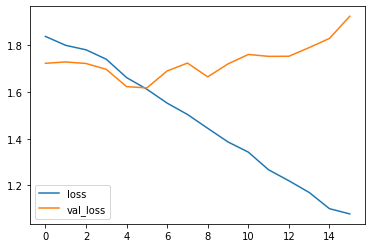

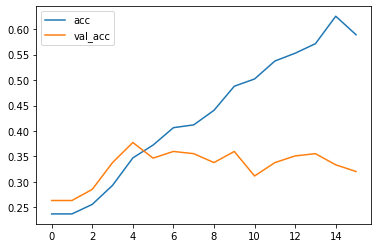

284/284 [==============================] - 2s 6ms/sample - loss: 1.7222 - accuracy: 0.3204


[1.7222332937616698, 0.32042253]

In [88]:
# some configuration
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'

VALIDATION_SPLIT = 0.2   
BATCH_SIZE = 1   # number of training samples to work through
EPOCHS = 1000   # number of complete passes through the training dataset
LEARNING_RATE = 0.001

print('Building Bi-LSTM model...')

model = tf.keras.Sequential([
    #Embedding

     tf.keras.layers.Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,dropout=0.5)),
     #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
     tf.keras.layers.GlobalAveragePooling1D(),
     tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(
  loss = 'categorical_crossentropy',
  optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
  metrics = ['accuracy'],
  
)

# Training model:
# parameters: batch_size, epoches
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
# load a saved model

from sklearn.utils import class_weight
##class_weights = class_weight.compute_class_weight('balanced', np.unique(positivity_train.values), positivity_train.values)
#class_weight_dict = dict(enumerate(class_weight))
y_train = positivity_train[['pos2','pos3','pos4','pos5','pos6','pos7','pos8','pos9']]
y_test = positivity_test[['pos2','pos3','pos4','pos5','pos6','pos7','pos8','pos9']]
print('Training model...')
r = model.fit(
  train_p,
  y_train.to_numpy(),
  batch_size = BATCH_SIZE,
  epochs = EPOCHS,
  validation_split = VALIDATION_SPLIT,
  callbacks=[es, mc]
  ##class_weight = class_weight_dict
  #use_multiprocessing=True
)

saved_model = tf.keras.models.load_model('best_model.h5')
saved_model.summary()


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

saved_model.evaluate(x = test_p, y = y_test.to_numpy())